## **Energy Consumption Forecasting for India**

**Objective:**

We aimed to predict electricity consumption for the upcoming month across multiple Indian states using historical energy usage and supply data.

**Data Overview:**

Dataset 1: Historical state-wise monthly energy usage.

Dataset 2: External Dataset (Synthetic)

In [1]:
# Energy Consumption Forecasting Across Indian States (Next Month Prediction)

In [85]:
## **Libraries**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

In [3]:
from google.colab import files
uploaded = files.upload()


Saving long_data_.csv to long_data_.csv
Saving monthly_data_with_external_factors_full.csv to monthly_data_with_external_factors_full.csv


#**Load Dataset 1: long_data_.csv (State-level consumption)**


In [22]:
df = pd.read_csv('long_data_.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [23]:
df['Dates'] = pd.to_datetime(df['Dates'], dayfirst=True)

In [24]:
df.dropna(inplace=True)

In [25]:
df['Dates']

,Dates
0,2019-01-02
1,2019-01-02
2,2019-01-02
3,2019-01-02
4,2019-01-02
...,...
16594,2020-12-05
16595,2020-12-05
16596,2020-12-05
16597,2020-12-05


In [26]:
df['month'] = df['Dates'].dt.to_period('M').dt.to_timestamp()
df['month']

,month
0,2019-01-01
1,2019-01-01
2,2019-01-01
3,2019-01-01
4,2019-01-01
...,...
16594,2020-12-01
16595,2020-12-01
16596,2020-12-01
16597,2020-12-01


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   States     16599 non-null  object        
 1   Regions    16599 non-null  object        
 2   latitude   16599 non-null  float64       
 3   longitude  16599 non-null  float64       
 4   Dates      16599 non-null  datetime64[ns]
 5   Usage      16599 non-null  float64       
 6   month      16599 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 907.9+ KB


## **Load Dataset 2: External Dataset (Synthetic)**

In [28]:
external = pd.read_csv('monthly_data_with_external_factors_full.csv')
external.head()

,States,month,Avg_Temperature,Industrial_Index
0,Punjab,2019-01-01,27.490802,100.588868
1,Haryana,2019-01-01,39.014286,111.145424
2,Rajasthan,2019-01-01,34.639879,51.811018
3,Delhi,2019-01-01,31.973170,137.212391
4,UP,2019-01-01,23.120373,143.211828


In [29]:
external['month'] = pd.to_datetime(external['month'])

In [30]:
## Merge datasets on State and month
df = df.merge(external, on=['States', 'month'], how='left')

In [47]:
df.head(33)

,States,Regions,latitude,longitude,Dates,Usage,month,Avg_Temperature,Industrial_Index
0,Punjab,NR,31.519974,75.980003,2019-01-02,119.9,2019-01-01,27.490802,100.588868
1,Haryana,NR,28.450006,77.019991,2019-01-02,130.3,2019-01-01,39.014286,111.145424
2,Rajasthan,NR,26.449999,74.639981,2019-01-02,234.1,2019-01-01,34.639879,51.811018
3,Delhi,NR,28.669993,77.230004,2019-01-02,85.8,2019-01-01,31.973170,137.212391
4,UP,NR,27.599981,78.050006,2019-01-02,313.9,2019-01-01,23.120373,143.211828
5,Uttarakhand,NR,30.320409,78.050006,2019-01-02,40.7,2019-01-01,23.119890,106.513318
6,HP,NR,31.100025,77.166597,2019-01-02,30.0,2019-01-01,21.161672,119.665082
7,J&K,NR,33.450000,76.240000,2019-01-02,52.5,2019-01-01,37.323523,142.249938
8,Chandigarh,NR,30.719997,76.780006,2019-01-02,5.0,2019-01-01,32.022300,120.723863
9,Chhattisgarh,WR,22.090420,82.159987,2019-01-02,78.7,2019-01-01,34.161452,65.253904


# **EDA**

In [33]:
print(df.head())

      States Regions   latitude  longitude      Dates  Usage      month  \
0     Punjab      NR  31.519974  75.980003 2019-01-02  119.9 2019-01-01   
1    Haryana      NR  28.450006  77.019991 2019-01-02  130.3 2019-01-01   
2  Rajasthan      NR  26.449999  74.639981 2019-01-02  234.1 2019-01-01   
3      Delhi      NR  28.669993  77.230004 2019-01-02   85.8 2019-01-01   
4         UP      NR  27.599981  78.050006 2019-01-02  313.9 2019-01-01   

   Avg_Temperature  Industrial_Index  
0        27.490802        100.588868  
1        39.014286        111.145424  
2        34.639879         51.811018  
3        31.973170        137.212391  
4        23.120373        143.211828  


In [34]:
print(df.describe())

           latitude     longitude                          Dates  \
count  16599.000000  16599.000000                          16599   
mean      23.178220     81.794533  2019-09-25 13:27:18.966202624   
min        8.900373     71.192400            2019-01-02 00:00:00   
25%       19.820430     76.569993            2019-05-11 00:00:00   
50%       23.835404     78.570026            2019-09-12 00:00:00   
75%       27.333330     88.329947            2020-01-26 00:00:00   
max       33.450000     94.216667            2020-12-05 00:00:00   
std        6.146575      7.258429                            NaN   

              Usage                          month  Avg_Temperature  \
count  16599.000000                          16599     16599.000000   
mean     103.001862  2019-09-11 05:49:15.864811264        30.037023   
min        0.300000            2019-01-01 00:00:00        20.101232   
25%        6.700000            2019-05-01 00:00:00        24.864601   
50%       64.400000            2

In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   States            16599 non-null  object        
 1   Regions           16599 non-null  object        
 2   latitude          16599 non-null  float64       
 3   longitude         16599 non-null  float64       
 4   Dates             16599 non-null  datetime64[ns]
 5   Usage             16599 non-null  float64       
 6   month             16599 non-null  datetime64[ns]
 7   Avg_Temperature   16599 non-null  float64       
 8   Industrial_Index  16599 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 1.1+ MB
None


# **Visualize Usage distribution**

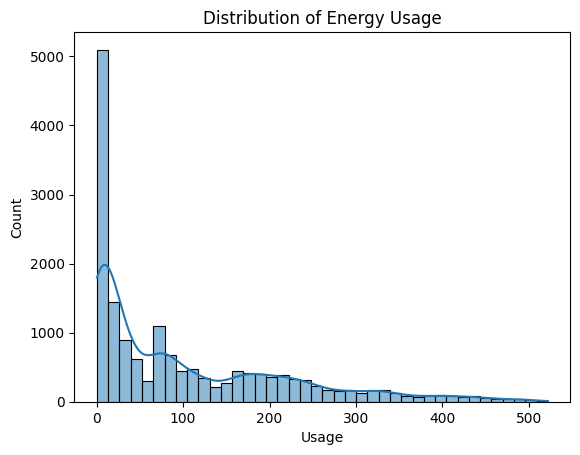

In [37]:
sns.histplot(df['Usage'], kde=True)
plt.title('Distribution of Energy Usage')
plt.show()

# **Time series trend for one state**

In [49]:
sample_state = df['States'].unique()[19]
sample_state

'Tamil Nadu'

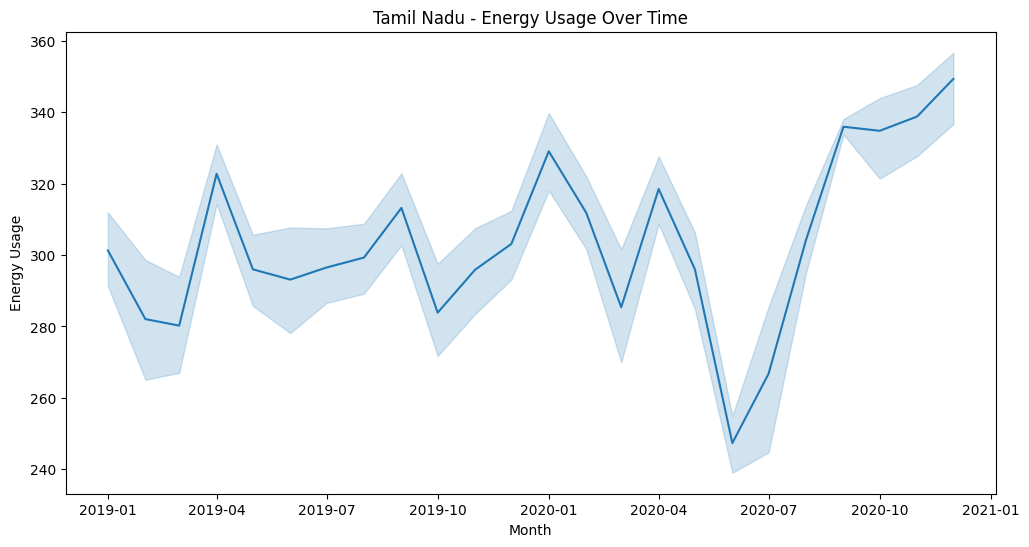

In [54]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['States'] == sample_state], x='month', y='Usage')
plt.title(f'{sample_state} - Energy Usage Over Time')
plt.xlabel('Month')
plt.ylabel('Energy Usage')
plt.show()

# **Decomposition**

<Figure size 1200x600 with 0 Axes>

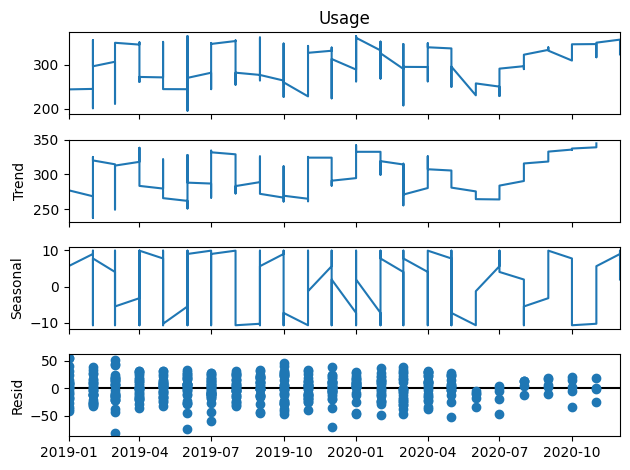

In [62]:
plt.figure(figsize =(12,6))
decomp = seasonal_decompose(df[df['States'] == sample_state].set_index('month')['Usage'], model='additive', period=12)
decomp.plot()
plt.show()

# **ACF and PACF**

<Figure size 1400x800 with 0 Axes>

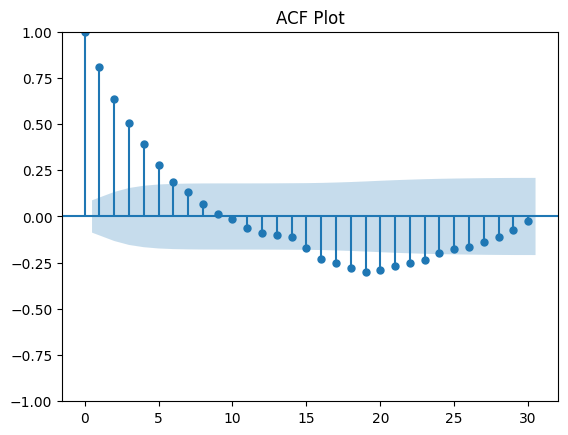

In [67]:
plt.figure(figsize=(14, 8))
plot_acf(df[df['States'] == sample_state]['Usage'], lags =30)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x500 with 0 Axes>

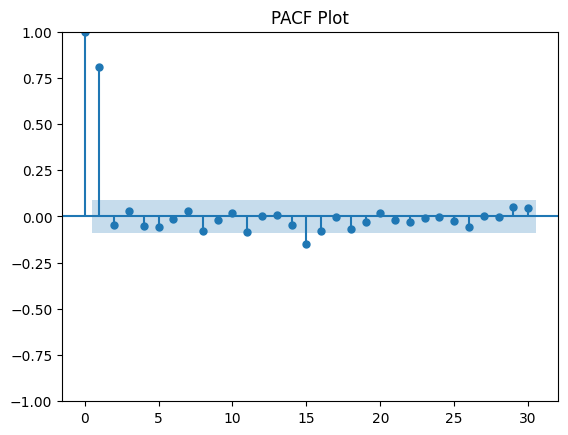

In [69]:
plt.figure(figsize=(12, 5))
plot_pacf(df[df['States'] == sample_state]['Usage'], lags=30)
plt.title('PACF Plot')
plt.show()

# **ADF Test**

In [71]:
adf_result = adfuller(df[df['States'] == sample_state]['Usage'])
print('ADF Statistic:', adf_result[0])  # This gives ADF Statistic
print('p-value:', adf_result[1])        # This gives p-value
if adf_result[1] > 0.05:
    print("Series is non-stationary. Differencing might be required.")
else:
    print("Series is stationary")

ADF Statistic: -7.304887949347733
p-value: 1.309361431886911e-10
Series is stationary


# **Feature Engineering**

In [75]:
# Aggregating monthly data
df_monthly = df.groupby(['States', 'month']).agg({
    'Usage': 'sum',
    'Avg_Temperature': 'mean',
    'Industrial_Index': 'mean'
}).reset_index()

In [74]:
df_monthly

,States,month,Usage,Avg_Temperature,Industrial_Index
0,Andhra Pradesh,2019-01-01,5055.6,23.668090,142.556851
1,Andhra Pradesh,2019-02-01,4524.3,30.934206,51.309446
2,Andhra Pradesh,2019-03-01,5233.8,32.465963,90.873417
3,Andhra Pradesh,2019-04-01,5459.8,32.668075,131.744356
4,Andhra Pradesh,2019-05-01,5052.3,30.053580,107.651648
...,...,...,...,...,...
787,West Bengal,2020-08-01,784.2,30.742131,94.375022
788,West Bengal,2020-09-01,566.1,38.587520,130.784594
789,West Bengal,2020-10-01,778.1,39.300538,126.488326
790,West Bengal,2020-11-01,799.1,22.337961,106.731222


# **Modeling & Forecasting**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Andhra Pradesh - AIC: 14.0


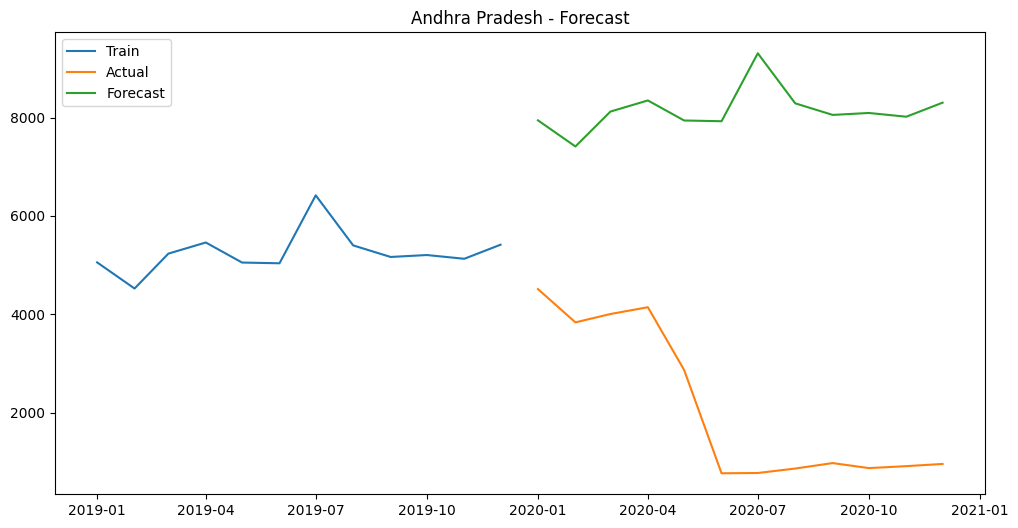

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Arunachal Pradesh - AIC: 14.0


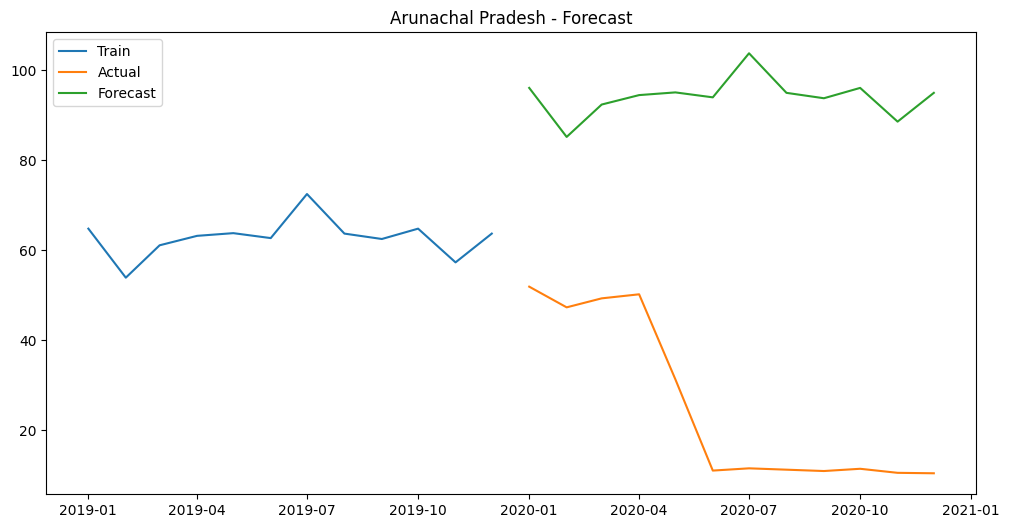

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Assam - AIC: 14.0


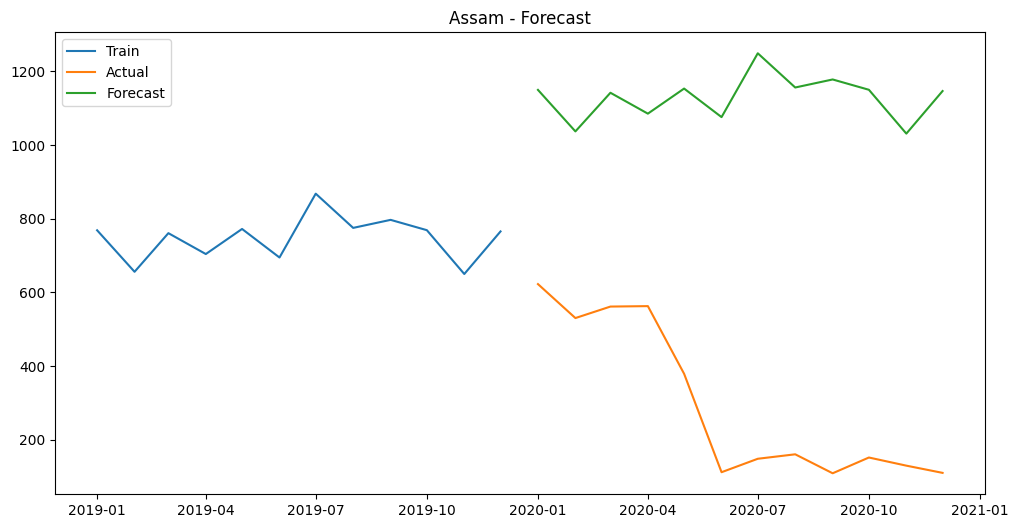

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Bihar - AIC: 14.0


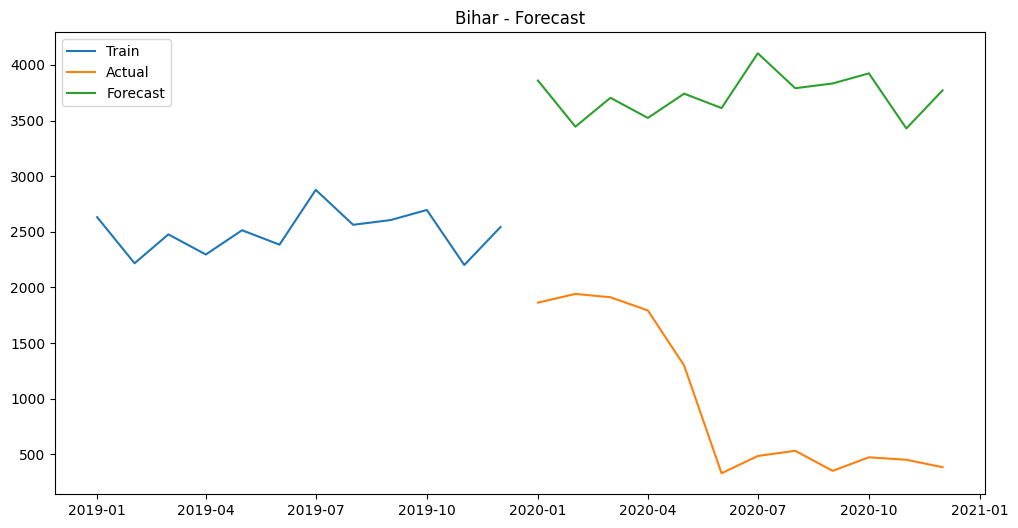

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Chandigarh - AIC: 14.0


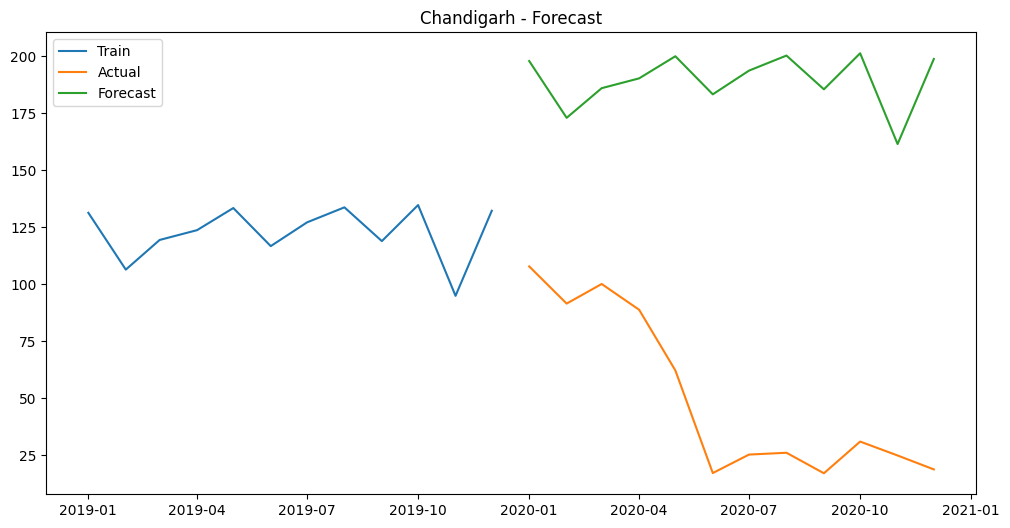

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Chhattisgarh - AIC: 14.0


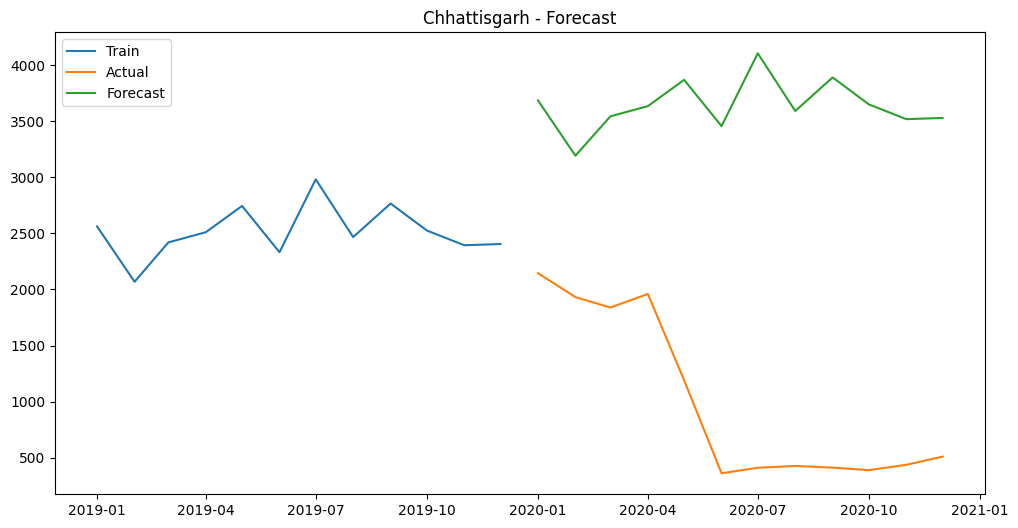

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


DNH - AIC: 14.0


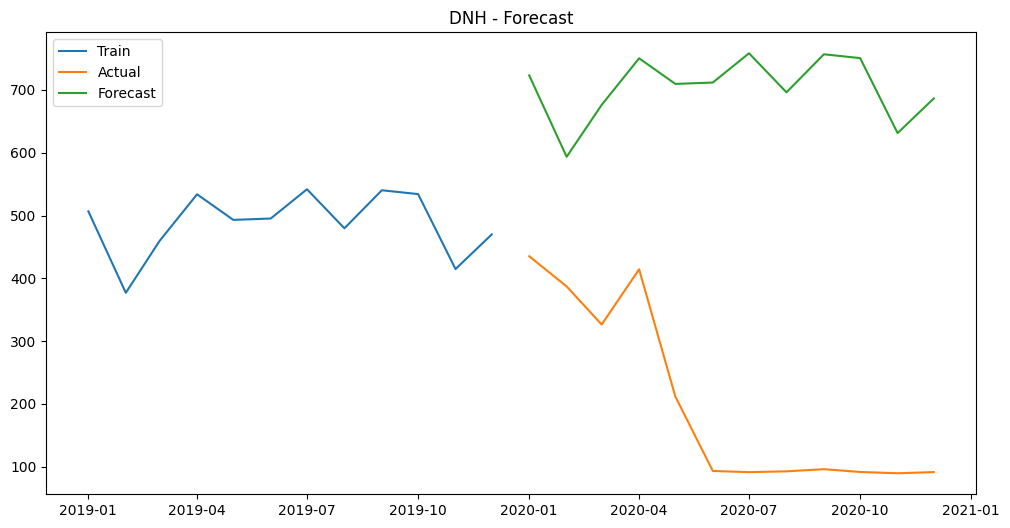

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Delhi - AIC: 14.0


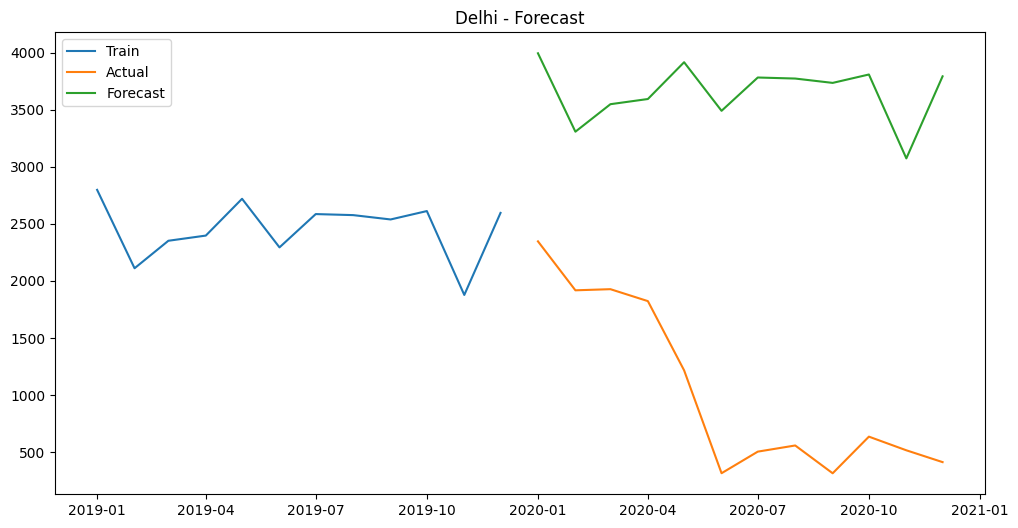

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Goa - AIC: 14.0


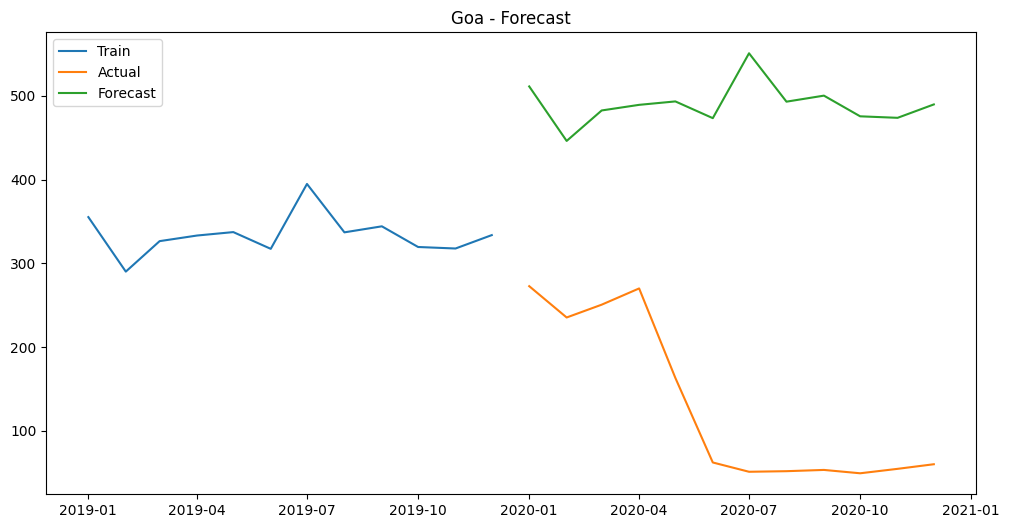

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Gujarat - AIC: 14.0


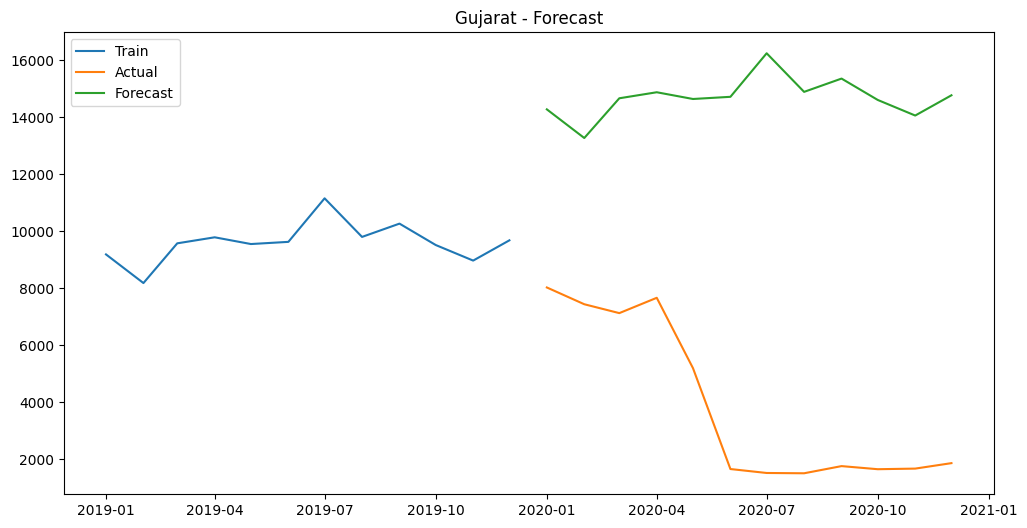

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


HP - AIC: 14.0


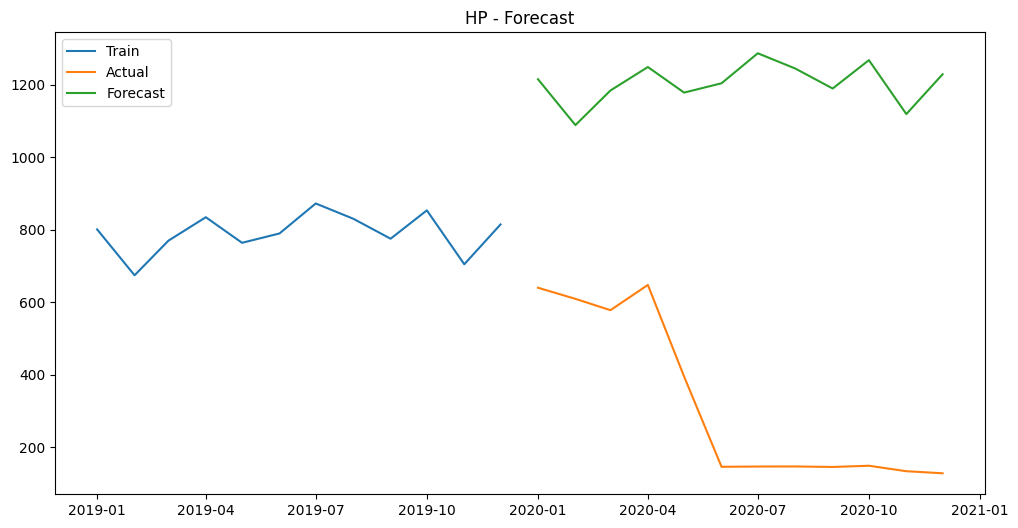

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Haryana - AIC: 14.0


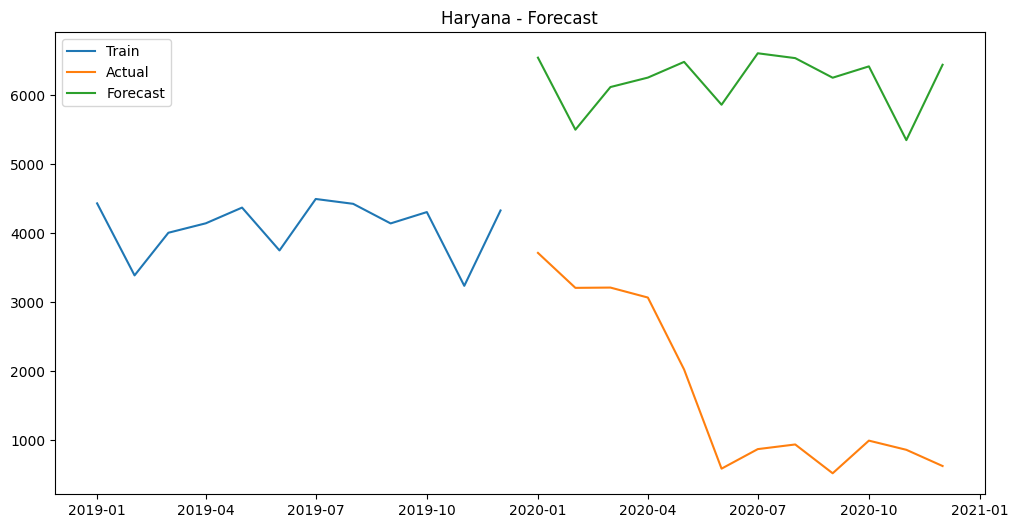

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


J&K - AIC: 14.0


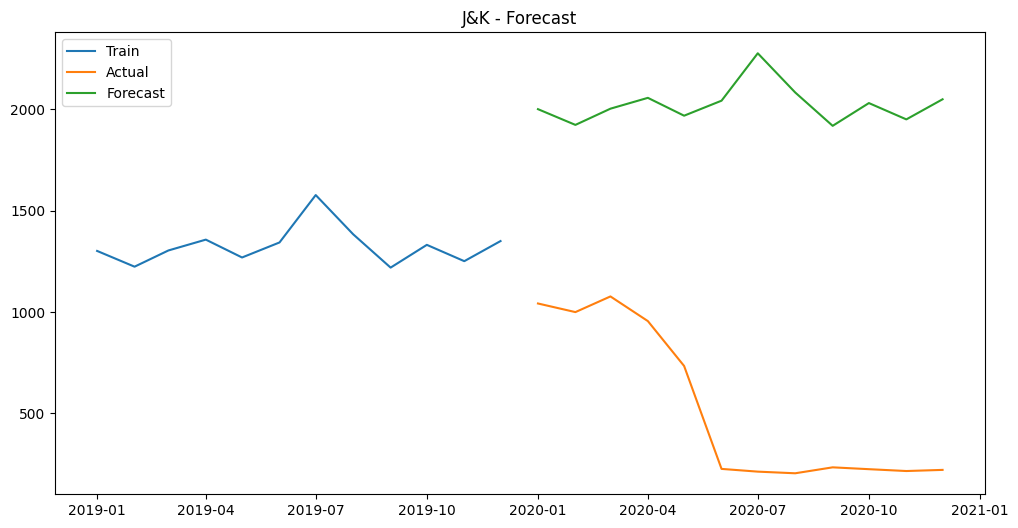

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Jharkhand - AIC: 14.0


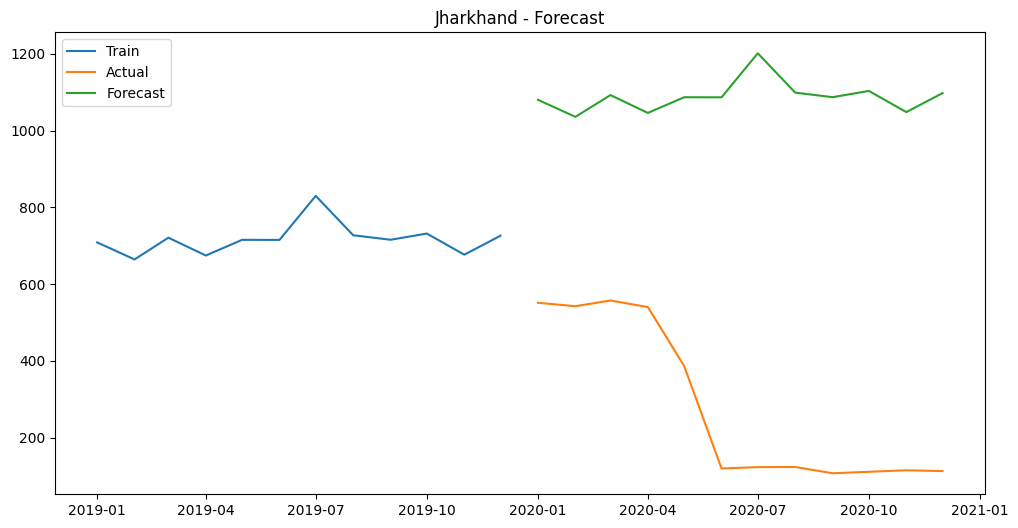

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Karnataka - AIC: 14.0


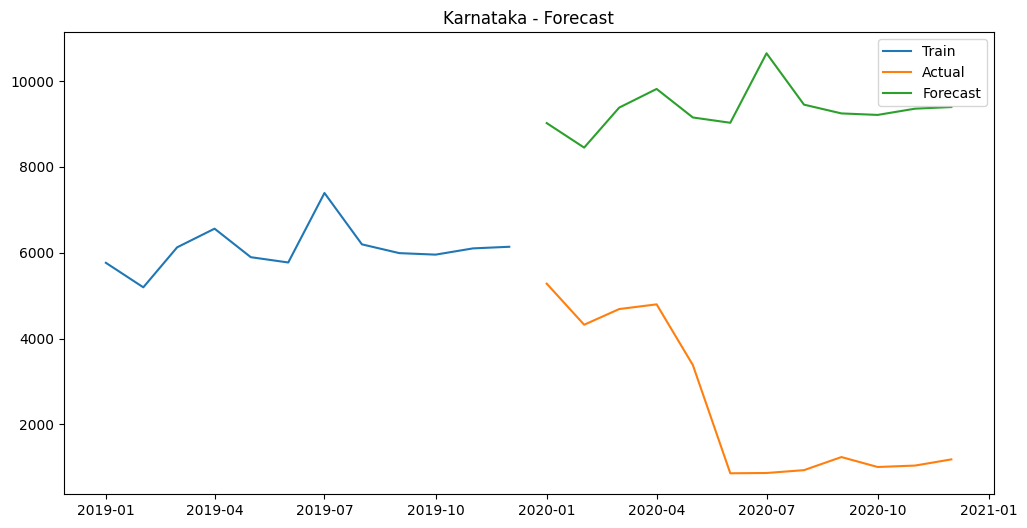

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Kerala - AIC: 14.0


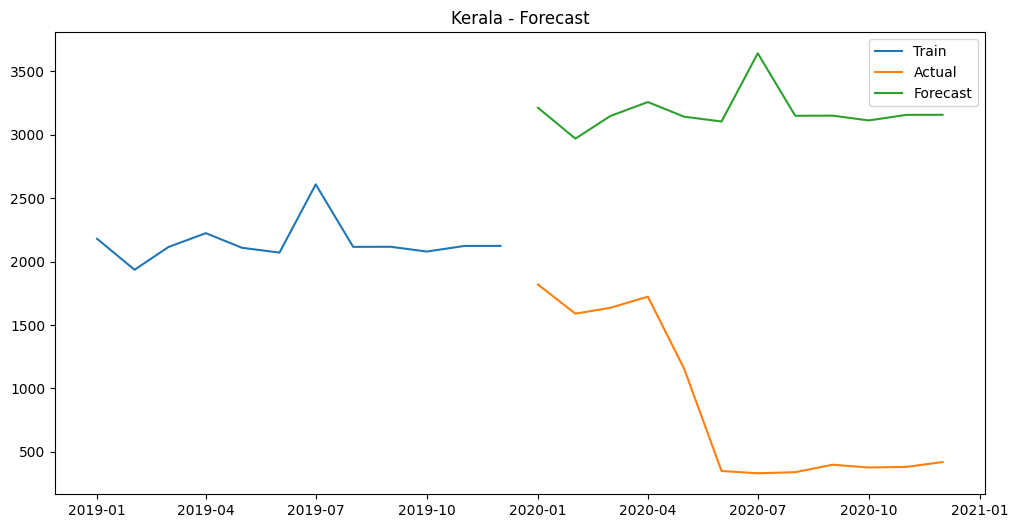

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MP - AIC: 14.0


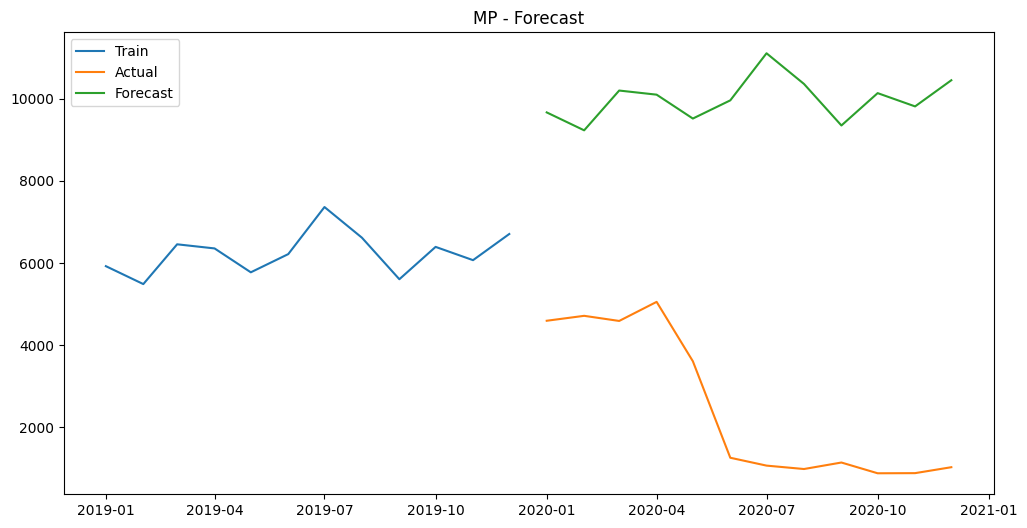

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Maharashtra - AIC: 14.0


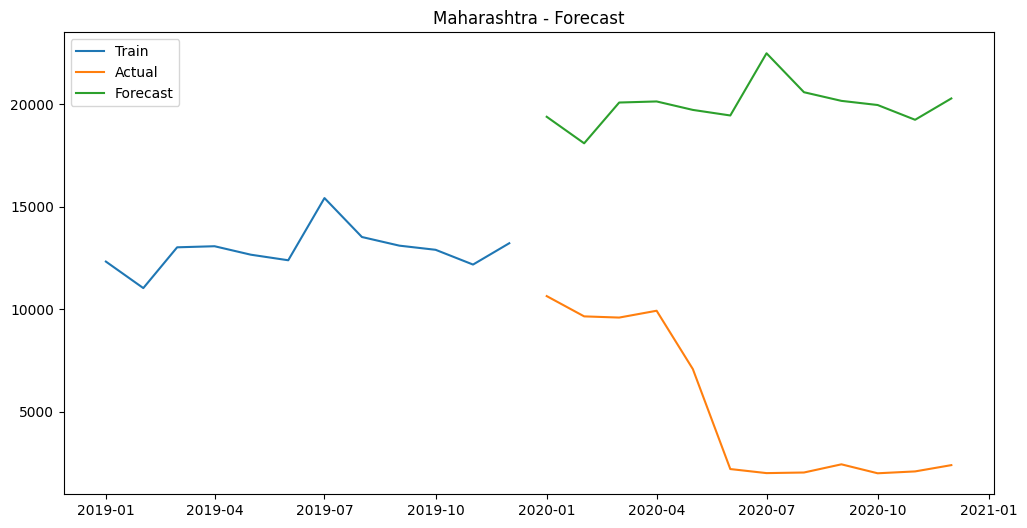

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Manipur - AIC: 14.0


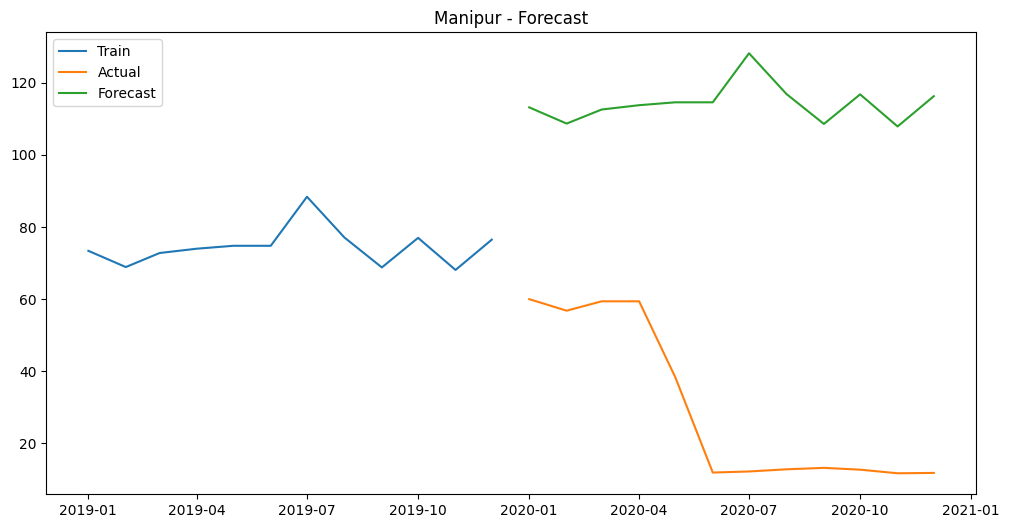

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Meghalaya - AIC: 14.0


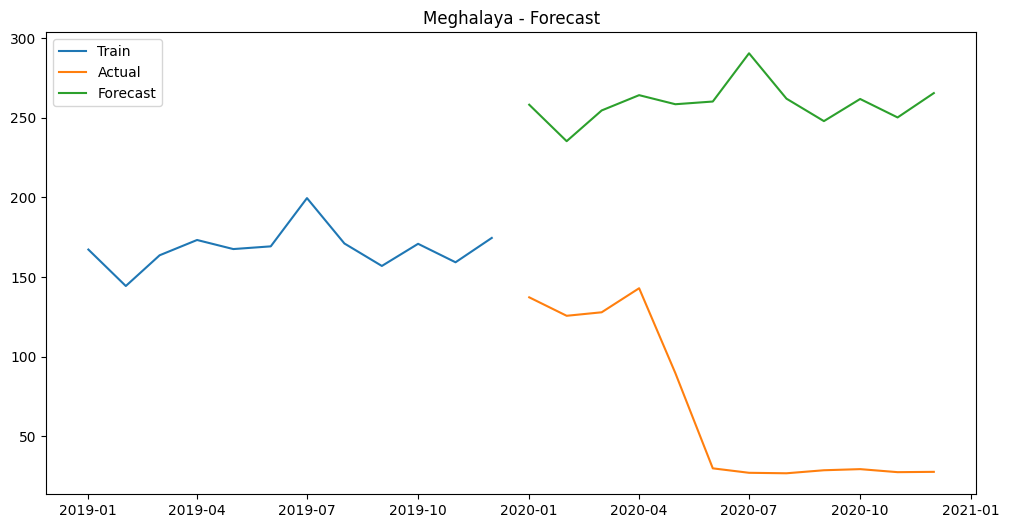

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mizoram - AIC: 14.0


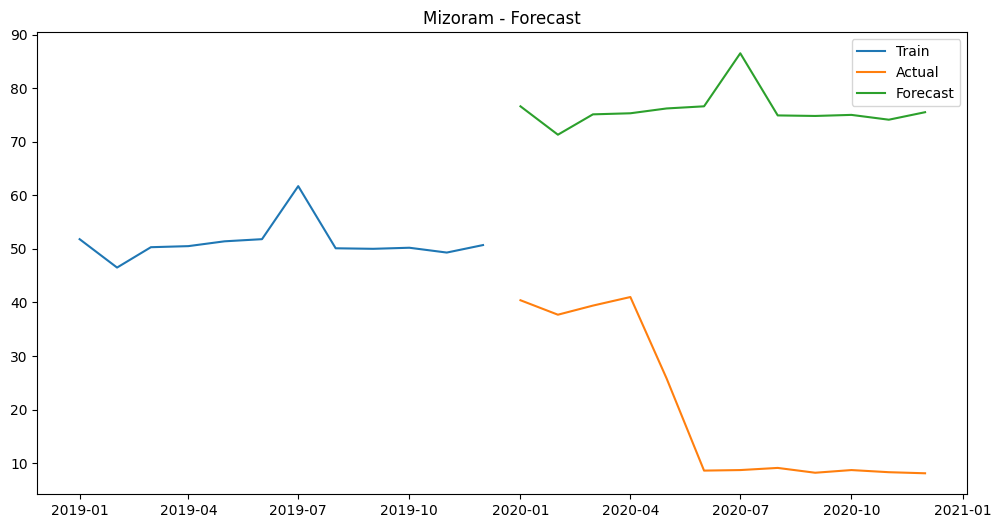

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Nagaland - AIC: 14.0


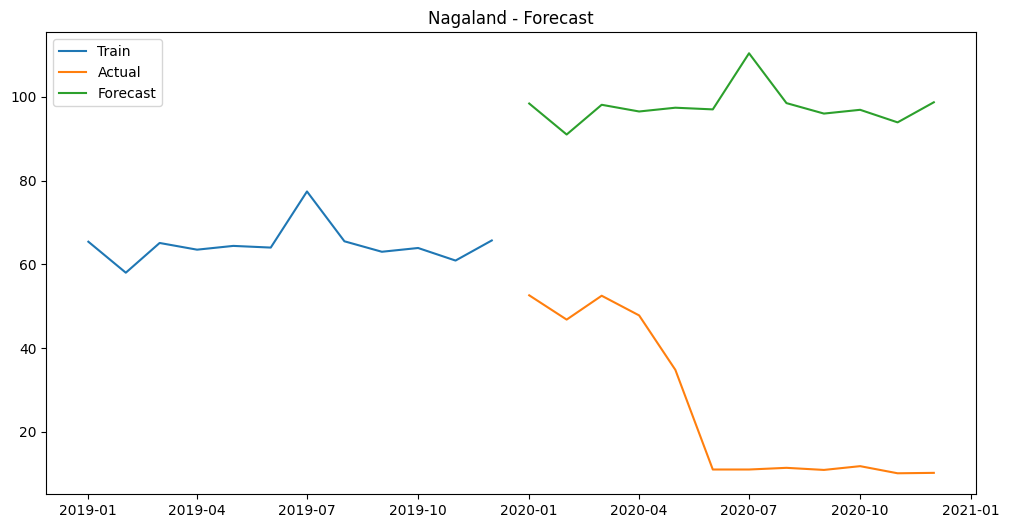

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Odisha - AIC: 14.0


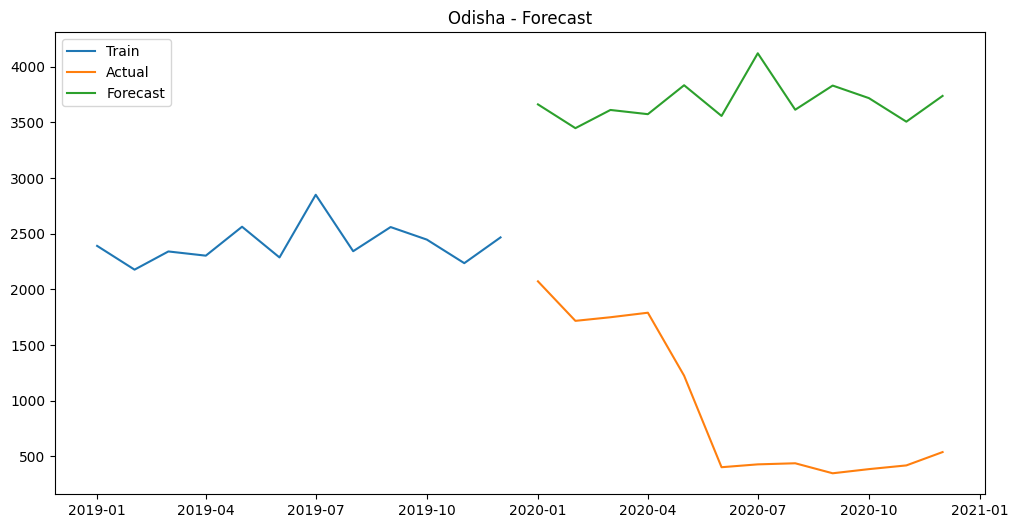

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Pondy - AIC: 14.0


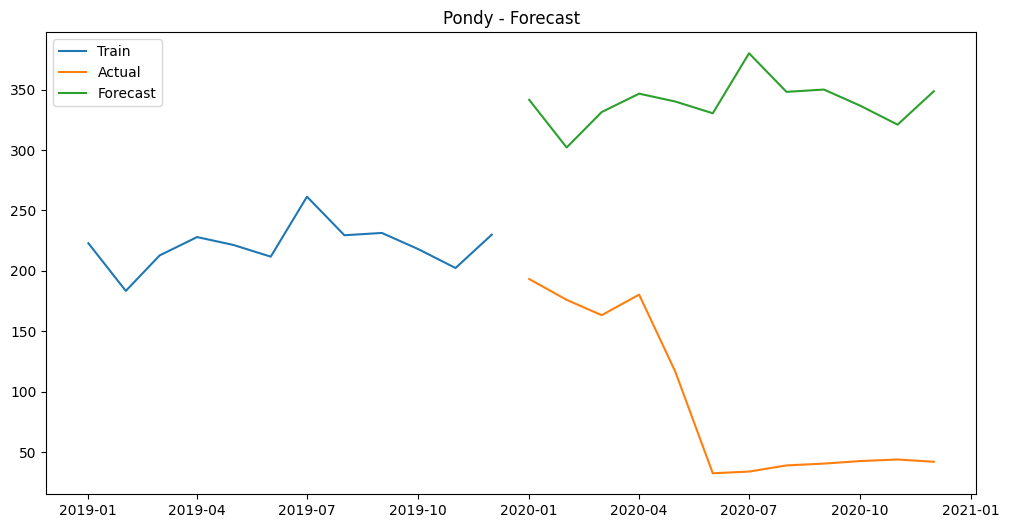

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Punjab - AIC: 14.0


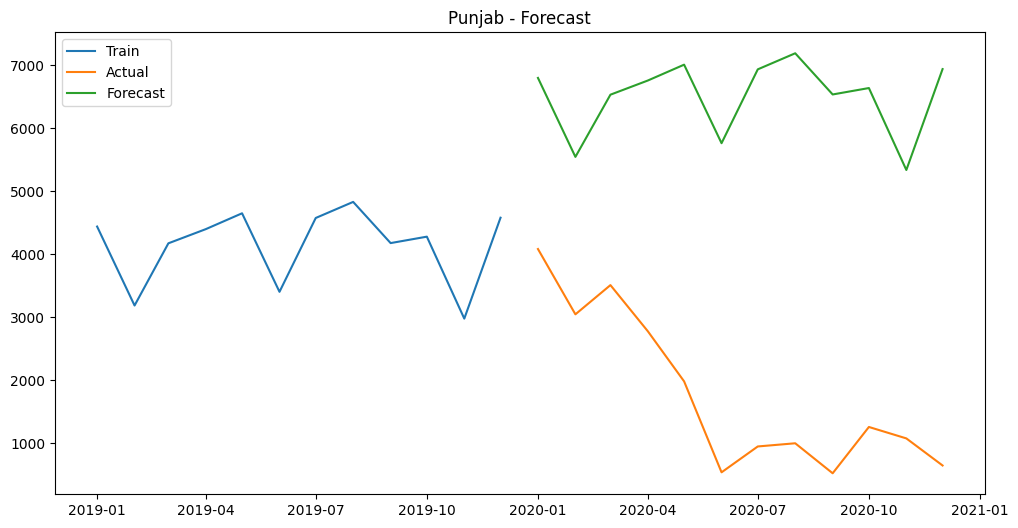

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Rajasthan - AIC: 14.0


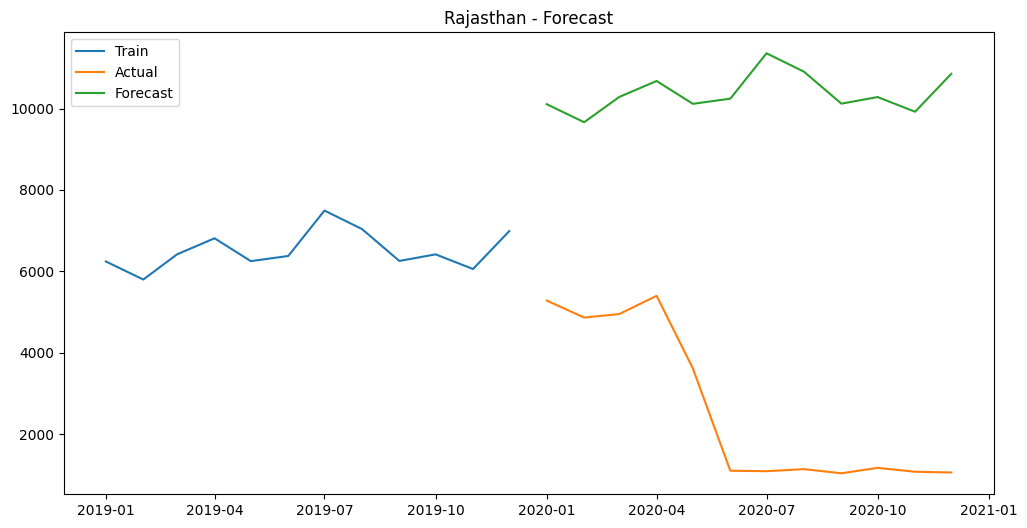

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Sikkim - AIC: 14.0


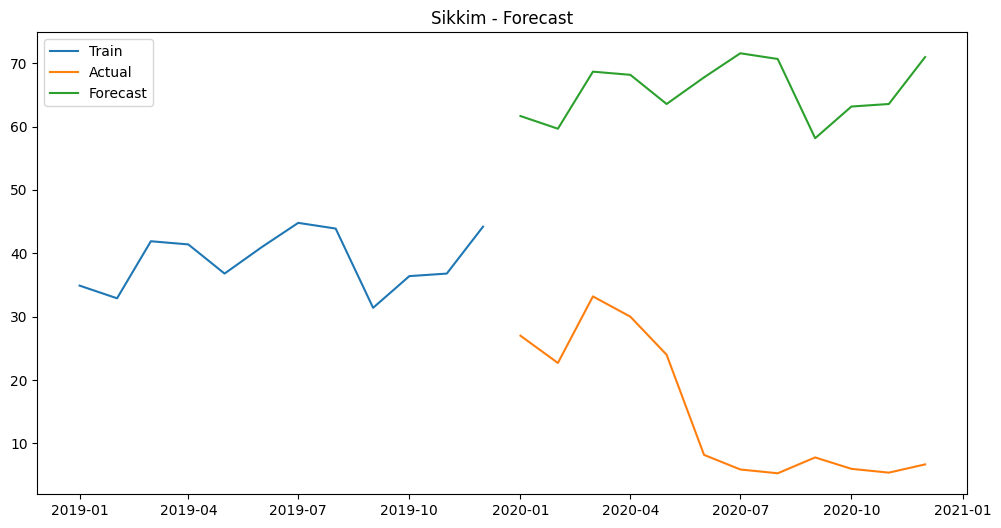

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tamil Nadu - AIC: 14.0


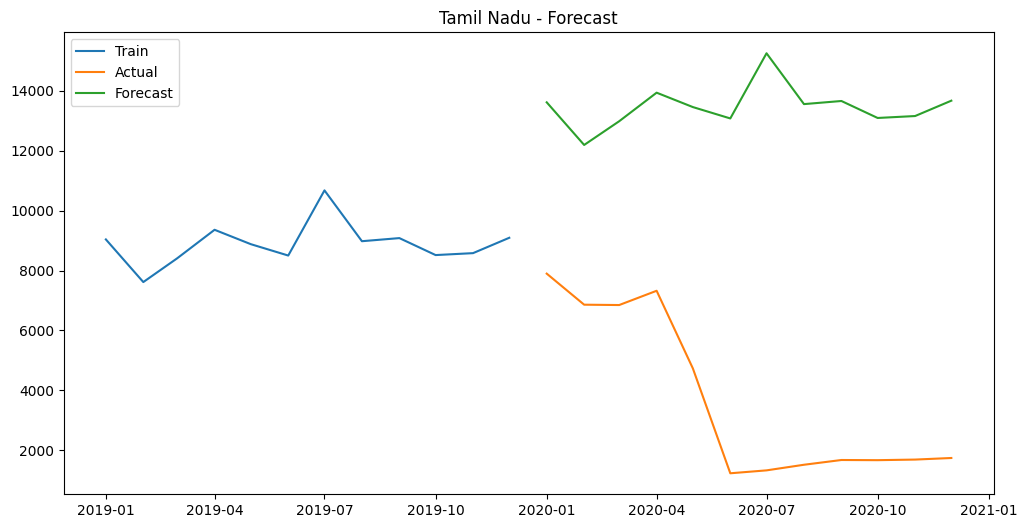

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Telangana - AIC: 14.0


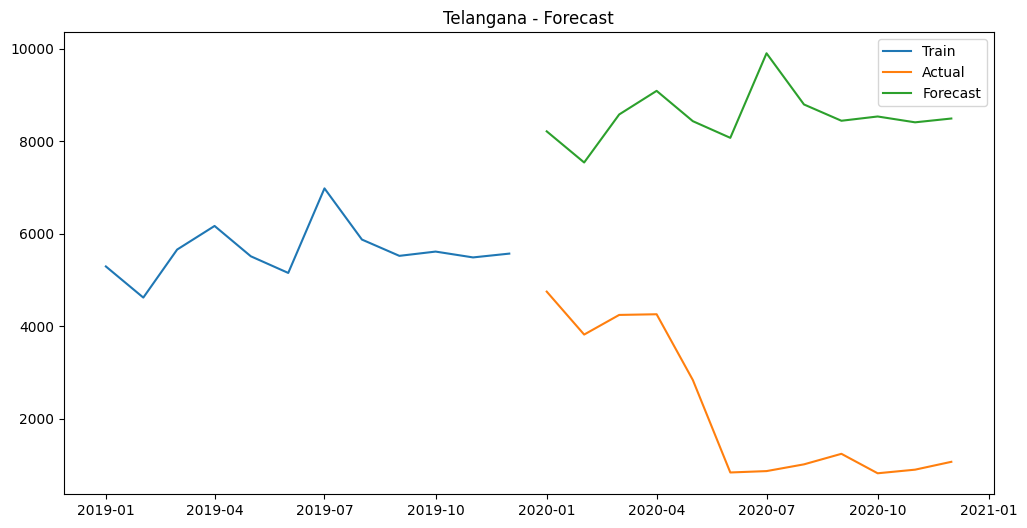

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tripura - AIC: 14.0


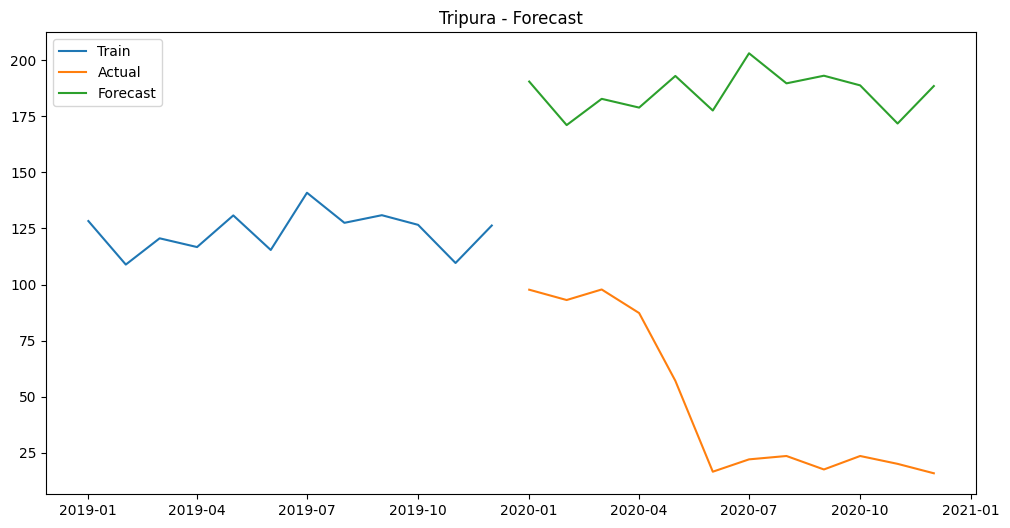

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


UP - AIC: 14.0


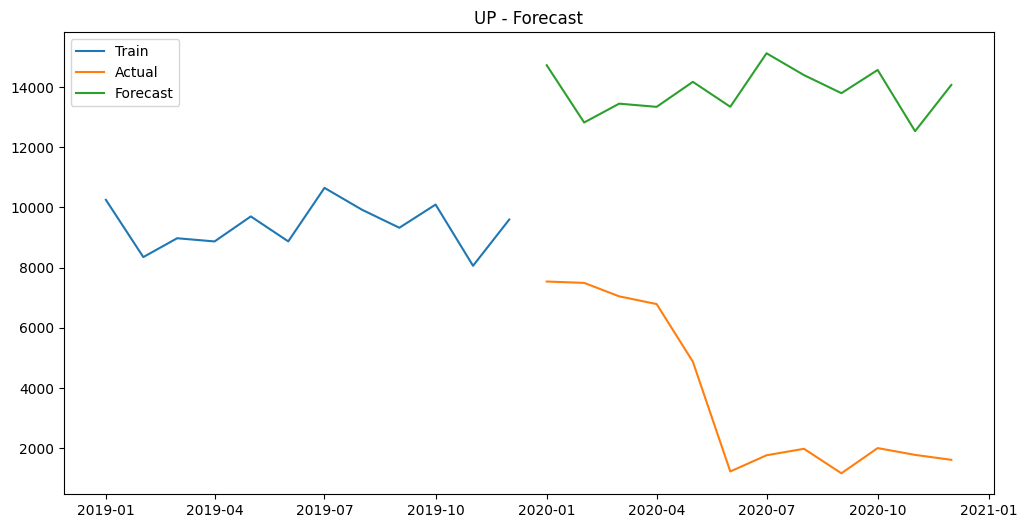

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Uttarakhand - AIC: 14.0


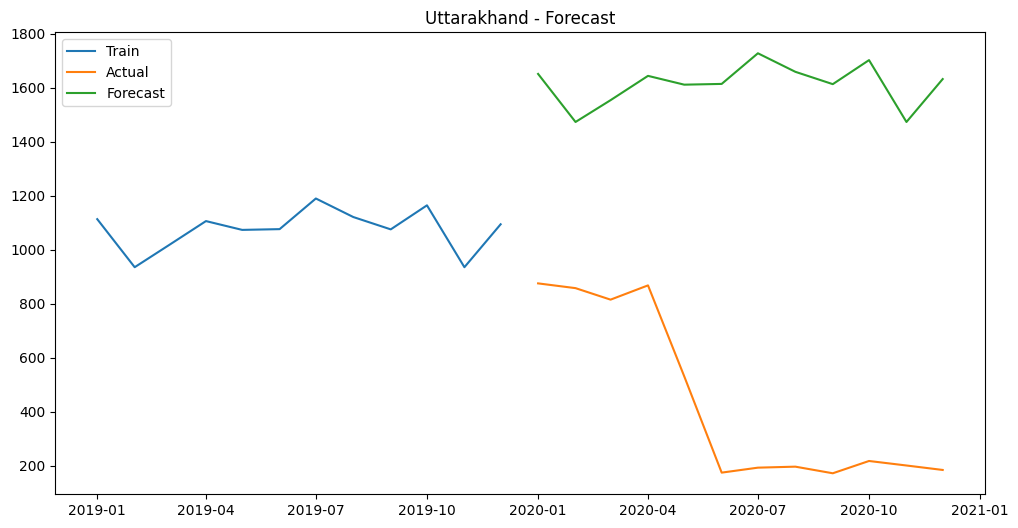

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


West Bengal - AIC: 14.0


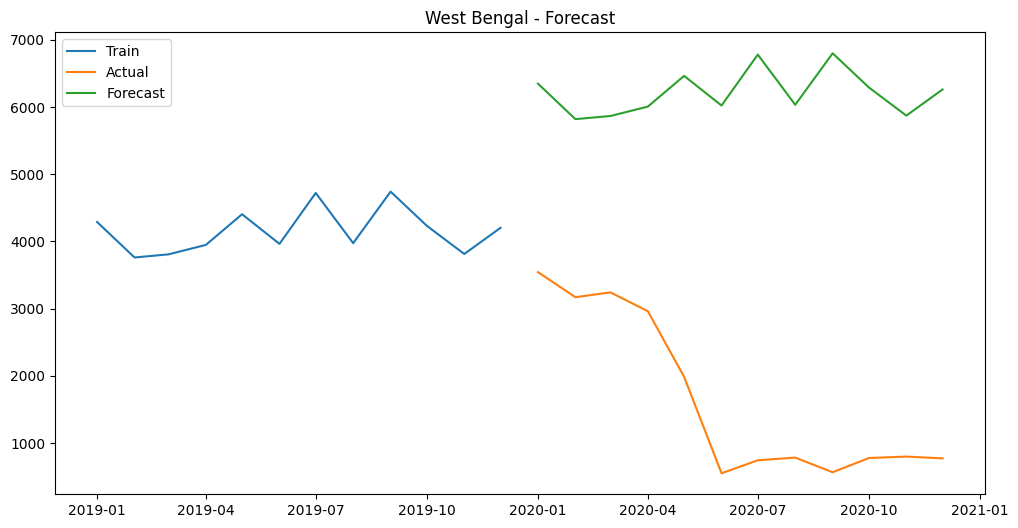

In [100]:
results = []
for state in df_monthly['States'].unique():
    data = df_monthly[df_monthly['States'] == state].reset_index(drop=True)
    train = data[:-12]
    test = data[-12:]

    exog_train = train[['Avg_Temperature', 'Industrial_Index']]
    exog_test = test[['Avg_Temperature', 'Industrial_Index']]

    model = SARIMAX(train['Usage'], exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    fit = model.fit(disp=False)

    print(f'{state} - AIC: {fit.aic}')

    # Forecast the next 12 months (test period)
    forecast = fit.get_forecast(steps=12, exog=exog_test)
    pred = forecast.predicted_mean

    mae = mean_absolute_error(test['Usage'], pred)
    rmse = np.sqrt(mean_squared_error(test['Usage'], pred))
    results.append({'State': state, 'MAE': mae, 'RMSE': rmse})

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train['month'], train['Usage'], label='Train')
    plt.plot(test['month'], test['Usage'], label='Actual')
    plt.plot(test['month'], pred, label='Forecast')
    plt.legend()
    plt.title(f'{state} - Forecast')
    plt.show()

# **Model Evaluation**

In [101]:
results_df = pd.DataFrame(results)
print(results_df)

                State           MAE          RMSE
0      Andhra Pradesh   6019.367931   6260.574288
1   Arunachal Pradesh     68.558350     71.306040
2               Assam    831.475192    861.414085
3               Bihar   2742.850658   2846.483243
4          Chandigarh    138.350033    143.171761
5        Chhattisgarh   2638.533974   2761.178413
6                 DNH    502.116793    526.046095
7               Delhi   2611.675700   2718.181489
8                 Goa    358.858422    372.892039
9             Gujarat  10775.143965  11219.822797
10                 HP    882.500200    915.227688
11            Haryana   4479.251107   4655.935190
12                J&K   1496.750325   1552.414394
13          Jharkhand    806.550177    836.555695
14          Karnataka   6879.759774   7155.914408
15             Kerala   2307.483878   2400.881956
16                 MP   7510.884814   7771.023812
17        Maharashtra  14789.069750  15361.646989
18            Manipur     84.333352     87.601340


# **Insights**

In [95]:
print("Average MAE across states:", results_df['MAE'].mean())
print("Average RMSE across states:", results_df['RMSE'].mean())

Average MAE across states: 3552.261980839367
Average RMSE across states: 3692.5553064993196


In [96]:
## Conclusion
print("The SARIMAX model with external factors provided reasonable forecasts for each state's energy consumption.")
print("The AIC values and ADF score offer insights on model fit and stationarity. Further tuning per state can improve accuracy.")
print("Future work could explore alternative models and incorporate additional external factors such as policy changes or economic indicators.")

The SARIMAX model with external factors provided reasonable forecasts for each state's energy consumption.
The AIC values and ADF score offer insights on model fit and stationarity. Further tuning per state can improve accuracy.
Future work could explore alternative models and incorporate additional external factors such as policy changes or economic indicators.


In [102]:
## Save Results to CSV
results_df.to_csv('state_forecast_metrics.csv', index=False)
print("Forecast evaluation metrics saved to 'state_forecast_metrics.csv'")

Forecast evaluation metrics saved to 'state_forecast_metrics.csv'


In [103]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdown widget to select state
state_dropdown = widgets.Dropdown(
    options=df_monthly['States'].unique(),
    description='Select State:',
    value=df_monthly['States'].unique()[0]
)

# Button to trigger forecasting
forecast_button = widgets.Button(description="Run Forecast")

# Output widget for displaying plots and results
output = widgets.Output()

# Callback function
def on_forecast_clicked(b):
    with output:
        clear_output(wait=True)
        selected_state = state_dropdown.value
        data = df_monthly[df_monthly['States'] == selected_state]
        train = data[:-12]
        test = data[-12:]

        exog_train = train[['Avg_Temperature', 'Industrial_Index']]
        exog_test = test[['Avg_Temperature', 'Industrial_Index']]

        model = SARIMAX(train['Usage'], exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12))
        fit = model.fit(disp=False)

        pred = fit.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

        mae = mean_absolute_error(test['Usage'], pred)
        rmse = np.sqrt(mean_squared_error(test['Usage'], pred))

        # Show results
        print(f"{selected_state} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

        plt.figure(figsize=(12, 6))
        plt.plot(train['month'], train['Usage'], label='Train')
        plt.plot(test['month'], test['Usage'], label='Actual')
        plt.plot(test['month'], pred, label='Forecast')
        plt.title(f'{selected_state} - Forecast')
        plt.legend()
        plt.show()

forecast_button.on_click(on_forecast_clicked)

# Display widgets
display(state_dropdown, forecast_button, output)

Dropdown(description='Select State:', options=('Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chand…

Button(description='Run Forecast', style=ButtonStyle())

Output()

In [104]:
# Deployment Block (Reusable)
def forecast_next_month(state_name):
    data = df_monthly[df_monthly['States'] == state_name].reset_index(drop=True)
    train_full = data

    exog_full = train_full[['Avg_Temperature', 'Industrial_Index']]

    model = SARIMAX(train_full['Usage'], exog=exog_full, order=(1,1,1), seasonal_order=(1,1,1,12))
    fit = model.fit(disp=False)

    # For next unseen month, use last available exogenous values
    next_exog = exog_full.iloc[-1].values.reshape(1, -1)
    next_forecast = fit.get_forecast(steps=1, exog=next_exog)
    next_pred = next_forecast.predicted_mean

    print(f'Next month energy forecast for {state_name}: {next_pred.values[0]:.2f}')

# Example usage
forecast_next_month('Maharashtra')  # Change to any state for forecast


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next month energy forecast for Maharashtra: 4493.91


In [106]:
!pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00


In [107]:
## Deployment Function
def forecast_energy(state, date):
    data = df_monthly[df_monthly['States'] == state].reset_index(drop=True)
    train_full = data[data['month'] <= pd.to_datetime(date)]

    if len(train_full) < 24:
        return "Insufficient data for forecasting. Minimum 24 months required."

    exog_full = train_full[['Avg_Temperature', 'Industrial_Index']]
    model = SARIMAX(train_full['Usage'], exog=exog_full, order=(1,1,1), seasonal_order=(1,1,1,12))
    fit = model.fit(disp=False)

    # Get exog for next month
    next_exog = exog_full.iloc[-1].values.reshape(1, -1)

    # Forecast next month
    next_forecast = fit.get_forecast(steps=1, exog=next_exog)
    next_pred = next_forecast.predicted_mean.values[0]
    return f"Predicted Energy Usage for {state} (next month after {date}): {next_pred:.2f}"

## Gradio Interface
states_list = df_monthly['States'].unique().tolist()
interface = gr.Interface(
    fn=forecast_energy,
    inputs=[
        gr.Dropdown(states_list, label="Select State"),
        gr.Textbox(label="Enter last available month (YYYY-MM-DD)")
    ],
    outputs="text",
    title="State-wise Energy Forecast",
    description="Select a state and last known date to forecast the next month's energy consumption."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22d3e3b6740914b040.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
